<font size=5>OrderFlow因子</font>  
参考《订单流交易》。参考因子探索：OrderFlow因子篇和观察篇。

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # 文件位于

import factors  # 因子计算
import data_utils  # 数据读取 data_utils_CB
import performance as perf  # IC计算
import plotting  #绘图

In [2]:
dl = data_utils.DataLoader()
dl.init_month_df('E:/jupyternote/QF/CryptalC/data/UDST_M/1m_data/')
# 计算未来收益率
data_utils.compute_future_rtn_for_all(dl)

In [3]:
import pandas as pd
import numpy as np

In [4]:
def cal_Z_score(factor_df, column_lists, span):
    '''Z-score'''
    for column_name in column_lists:
        mean_20 = factor_df[column_name].ewm(span, adjust=False).mean()
        std_20 = factor_df[column_name].ewm(96, adjust=False).std()  # todo 超参数搜索
        factor_df[f'{column_name}_Z'] = (factor_df[column_name].values - mean_20) / std_20
    return factor_df

@factors.handle_dataloader_data
def add_close_Z(raw_df:pd.DataFrame)-> pd.DataFrame:
    raw_df = cal_Z_score(raw_df, ['close'], 30)
    return raw_df

## 计算Orderflow因子

In [5]:
@factors.handle_dataloader_data
def add_orderflow_factors(raw_df):
    '''
    2. 目前的 主买/卖方力量对比 
        - 供给失衡 supply_imb : 供给高于上一位需求的倍数 
            - supply(t) / demand(t-1)
        - 需求失衡 demand_imb : 
            - demand(t) / supply(t-1)
    3. 买卖方力量的变化情况
        - 供给衰竭 supply_imb : 
            - supply(t-1) / supply(t) * demand(t) / demand(t-1)
        - 需求衰竭 demand_exh : 
            - demand(t-1) / demand(t) * supply(t) / supply(t-1)
    4. 买卖方力量的相对于平均值的大小
    '''
    # 1. 先取出中间变量
    agg_df = raw_df[['close', 'taker_buy_quote_volume', 'quote_volume']]
    agg_df.columns = ['close', 'buy_taker', 'sum_quantity']
    agg_df['sell_taker'] = agg_df['sum_quantity'] - agg_df['buy_taker']
    # 去除0值
    agg_df['sell_taker'] = agg_df['sell_taker'].replace(0, 1e-5)
    agg_df['buy_taker'] = agg_df['buy_taker'].replace(0, 1e-5)
    agg_df['sum_quantity'] = agg_df['sum_quantity'].replace(0, 2e-5)
    
    # 2. 计算因子
    factors_df = pd.DataFrame()
    factors_df['order_imb'] =  np.log(agg_df['buy_taker'] / agg_df['sell_taker'])
    factors_df['demand_imb'] = agg_df['buy_taker'] / agg_df['sell_taker'].shift(1)
    factors_df['supply_imb'] = agg_df['sell_taker'] / agg_df['buy_taker'].shift(1)
    factors_df['demand_exh'] = agg_df['sell_taker'].ewm(5).mean() * agg_df['buy_taker'] / agg_df['sell_taker']  * agg_df['buy_taker'].ewm(5).mean()
    factors_df['demand_exh_X'] = np.log((agg_df['sell_taker'].ewm(5).mean() * agg_df['buy_taker']) / (agg_df['sell_taker']  * agg_df['buy_taker'].ewm(5).mean()))
    factors_df['supply_exh'] = agg_df['buy_taker'].ewm(5).mean() / agg_df['buy_taker'] * agg_df['sell_taker'] / agg_df['sell_taker'].ewm(5).mean()
    factors_df['relative_OrderSize'] = agg_df['sum_quantity'] / agg_df['sum_quantity'].ewm(100).mean()
    # factors_df = pd.DataFrame()
    # factors_df['demand_imb'] = agg_df['buy_taker'].ewm(5).mean() / agg_df['sell_taker'].ewm(30).mean() # 负相关
    # factors_df['supply_imb'] = agg_df['sell_taker'].ewm(5).mean() / agg_df['buy_taker'].ewm(30).mean() # 正相关
    # factors_df['demand_exh'] = agg_df['buy_taker'] / agg_df['sell_taker'].ewm(5).mean()  # 测试，注意buy和sell反了
    # factors_df['supply_exh'] = agg_df['sell_taker'] / agg_df['buy_taker'].ewm(5).mean()  # 测试，注意buy和sell反了
    # factors_df['relative_OrderSize'] = agg_df['sum_quantity'] / agg_df['sum_quantity'].ewm(100).mean()
    
    
    # 3. 合并
    raw_df = pd.concat([raw_df, factors_df], axis=1)
    return raw_df

In [6]:
@factors.handle_dataloader_data
def add_ta_factors(raw_df):
    raw_df.ta.squeeze(append=True)
    raw_df.ta.pgo(append=True)
    raw_df.ta.thermo(append=True)
    raw_df.ta.pvo(append=True)
    raw_df.ta.rsi(append=True)
    raw_df['macd'] = raw_df.ta.macd()['MACD_12_26_9']
    return raw_df

In [7]:
add_ta_factors(dl)

year: 2020


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.76it/s]


year: 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.86it/s]


year: 2022


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.01it/s]


year: 2023


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.32it/s]


In [8]:
# 计算因子
add_orderflow_factors(dl)

year: 2020


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.40it/s]


year: 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.48it/s]


year: 2022


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.37it/s]


year: 2023


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.89it/s]


In [9]:
add_close_Z(dl)

year: 2020


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 164.87it/s]


year: 2021


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 93.83it/s]


year: 2022


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 168.67it/s]


year: 2023


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 117.12it/s]


In [10]:
from ml_performance import MLFactorEvaluator

In [11]:
from xgboost import XGBClassifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
test_df = dl.get_month_df('2023','10')[0].copy()

In [14]:
record_names = [
    'baseline', 'orderflow'
]
factor_names = [
    [ 'RSI_14', 'macd', 'quote_volume'], 
    ['RSI_14', 'macd', 'quote_volume',
     'order_imb',
    'demand_imb',
    'supply_imb',
    'demand_exh',
    'relative_OrderSize',],
]

In [29]:
xgb_best_params = {
    'max_depth': 8,
    'n_estimators': 100,
    'n_jobs': 4,
    'reg_lambda': 10,
    'subsample': 0.5,
    'gamma': 5
}

# 小的maxdepth + 适中的n_estimators，保证每棵树采用不同特征，关注不同特点。然后再ensemble防止过拟合。
rf_best_params = {
    'max_depth': 5,
    'n_estimators': 50,
    'max_features': 'sqrt',
    'min_samples_leaf': 10,
    'n_jobs': -1,
    'criterion': 'gini'
}

In [30]:
import importlib

# 想要重新导入的模块名
module_name = 'ml_performance'

# 使用importlib.reload()重新导入模块
reloaded_module = importlib.reload(importlib.import_module(module_name))


In [31]:
ml_evaluator = reloaded_module.MLFactorEvaluator(
    method = RandomForestClassifier, 
    record_names = record_names, 
    factor_names = factor_names,
    params_dict = rf_best_params,
    cv = 5,
)

In [32]:
ml_evaluator.evaluate(dl, 'fwd_rtn_5_bool', subset_data=0.5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.04s/it]


In [33]:
ml_record = ml_evaluator.get_assess_df('auc')

In [34]:
plotting.plot_ML_table(ml_record)

Machine Learning records


,0,1,2,3,4,mean,std
baseline,0.6216,0.5874,0.6098,0.6159,0.5929,0.6055,0.0147
orderflow,0.6214,0.5875,0.6094,0.6163,0.5930,0.6055,0.0147


Machine Learning T-test Analysis


,t_ind,p_ind,t_rel,p_rel
record_name,,,,
orderflow,0.0013,0.999,0.0945,0.9293


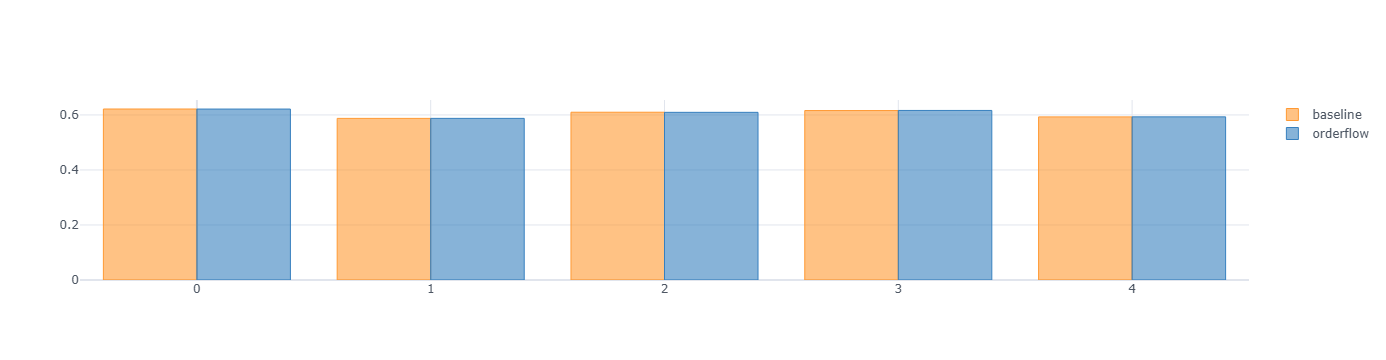

In [35]:
plotting.plot_ML_records(ml_record)

# 观察因子ICIR 

In [22]:
import performance as perf  # IC计算

Factor: order_imb
Information Analysis


,fwd_rtn_1_real,fwd_rtn_5_real,fwd_rtn_10_real,fwd_rtn_20_real,fwd_rtn_50_real,fwd_rtn_10_abs
IC Mean,-0.021,-0.072,-0.070,-0.058,-0.044,-0.001
IC Std.,0.018,0.015,0.012,0.010,0.008,0.007
Risk-Adjusted IC,-1.202,-4.673,-5.623,-5.687,-5.243,-0.194
t-stat(IC),-8.326,-32.378,-38.959,-39.400,-36.322,-1.345
p-value(IC),0.000,0.000,0.000,0.000,0.000,0.185
IC Skew,2.195,0.672,0.397,-0.011,-0.369,0.368
IC Kurtosis,6.883,1.803,1.311,0.630,0.078,0.130


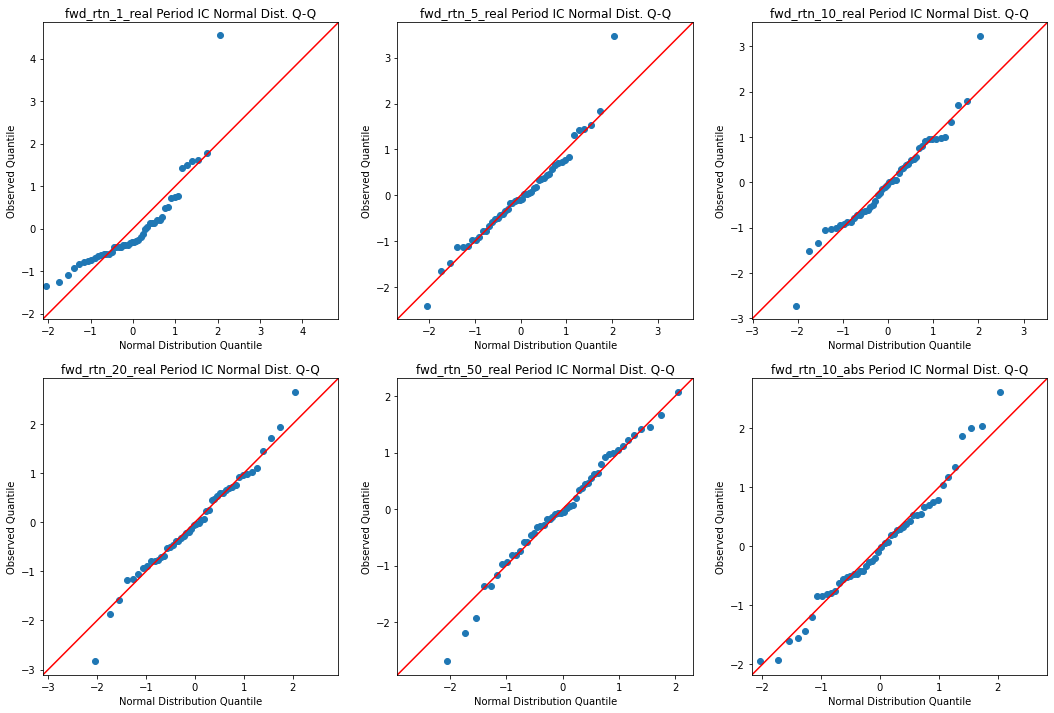

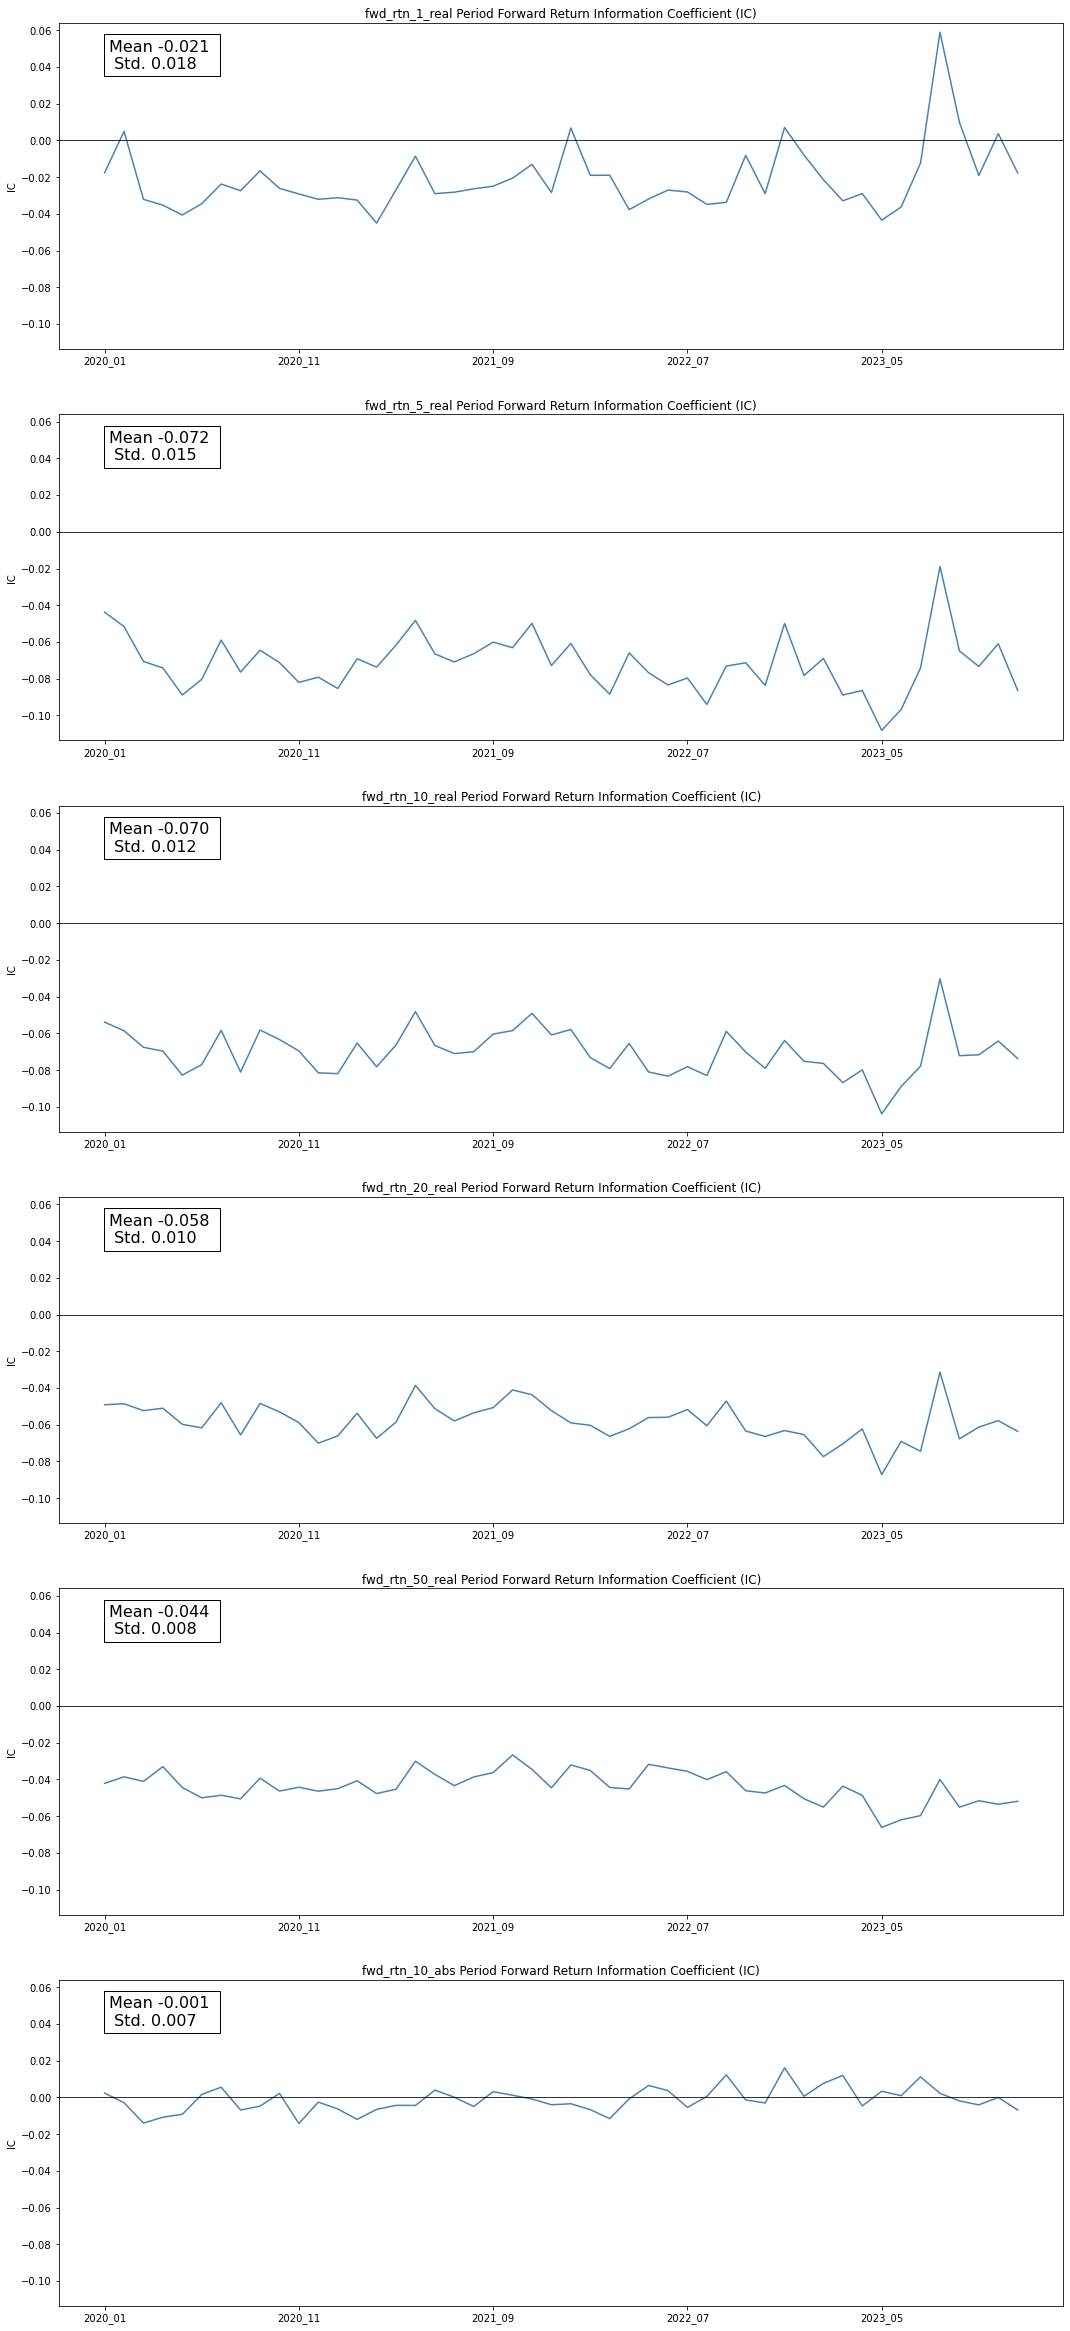

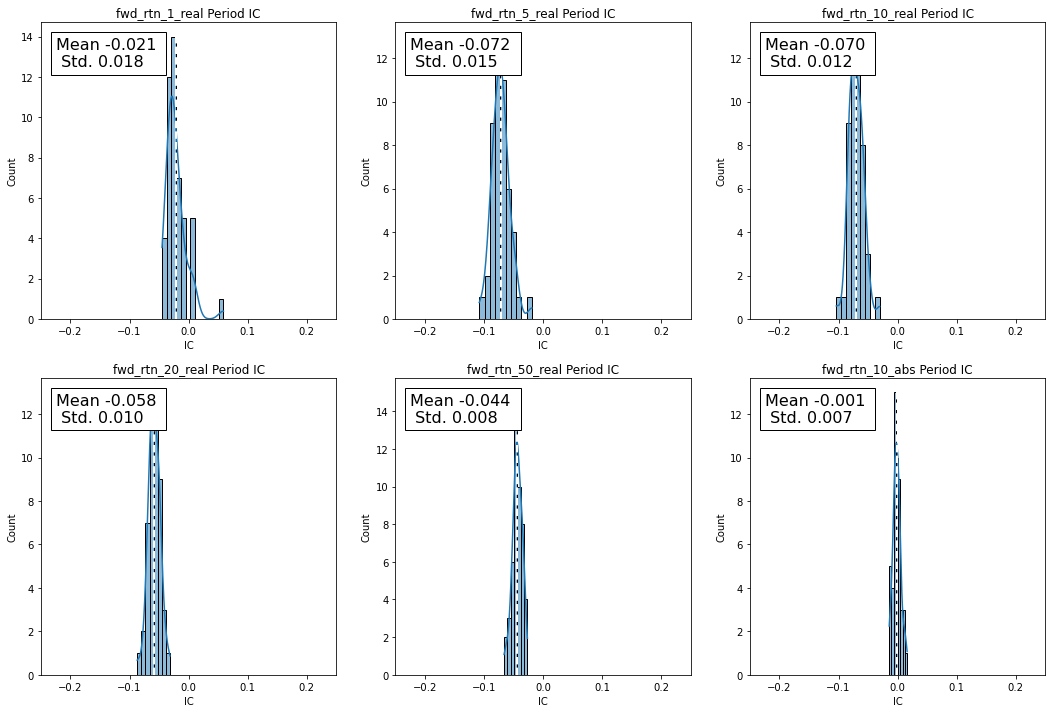

In [23]:
tests_factor_name='order_imb'
print(f'Factor: {tests_factor_name}')
month_mean_ic = perf.cal_monthly_mean_ic(dl, factor_name=tests_factor_name, use_real_rtn=True)
# 保存记录
dl.set_record_df(kind='Info', factor_name=tests_factor_name, result_df=month_mean_ic)
# 读取记录，并且展示作图
month_mean_ic = dl.get_record_df(kind='Info', factor_name=tests_factor_name)
plotting.plot_information_table(month_mean_ic)
plotting.plot_ic_qq(month_mean_ic)
plotting.plot_ic_ts(month_mean_ic)
plotting.plot_ic_hist(month_mean_ic)
plt.show()

Factor: supply_imb
Information Analysis


,fwd_rtn_1_real,fwd_rtn_5_real,fwd_rtn_10_real,fwd_rtn_20_real,fwd_rtn_50_real,fwd_rtn_10_abs
IC Mean,0.017,0.040,0.043,0.043,0.041,0.039
IC Std.,0.009,0.010,0.010,0.010,0.011,0.010
Risk-Adjusted IC,1.826,3.924,4.384,4.223,3.686,3.892
t-stat(IC),12.651,27.187,30.376,29.258,25.534,26.966
p-value(IC),0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,0.206,0.186,-0.064,-0.427,-0.311,0.072
IC Kurtosis,-0.215,-0.612,-0.584,-0.539,-0.416,-0.426


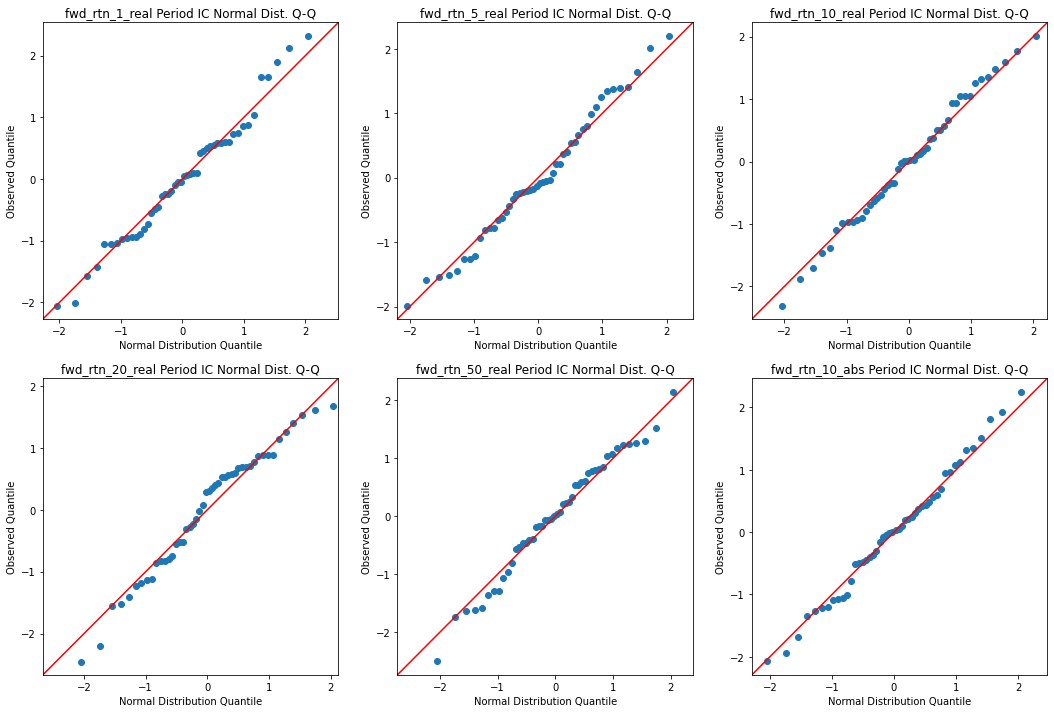

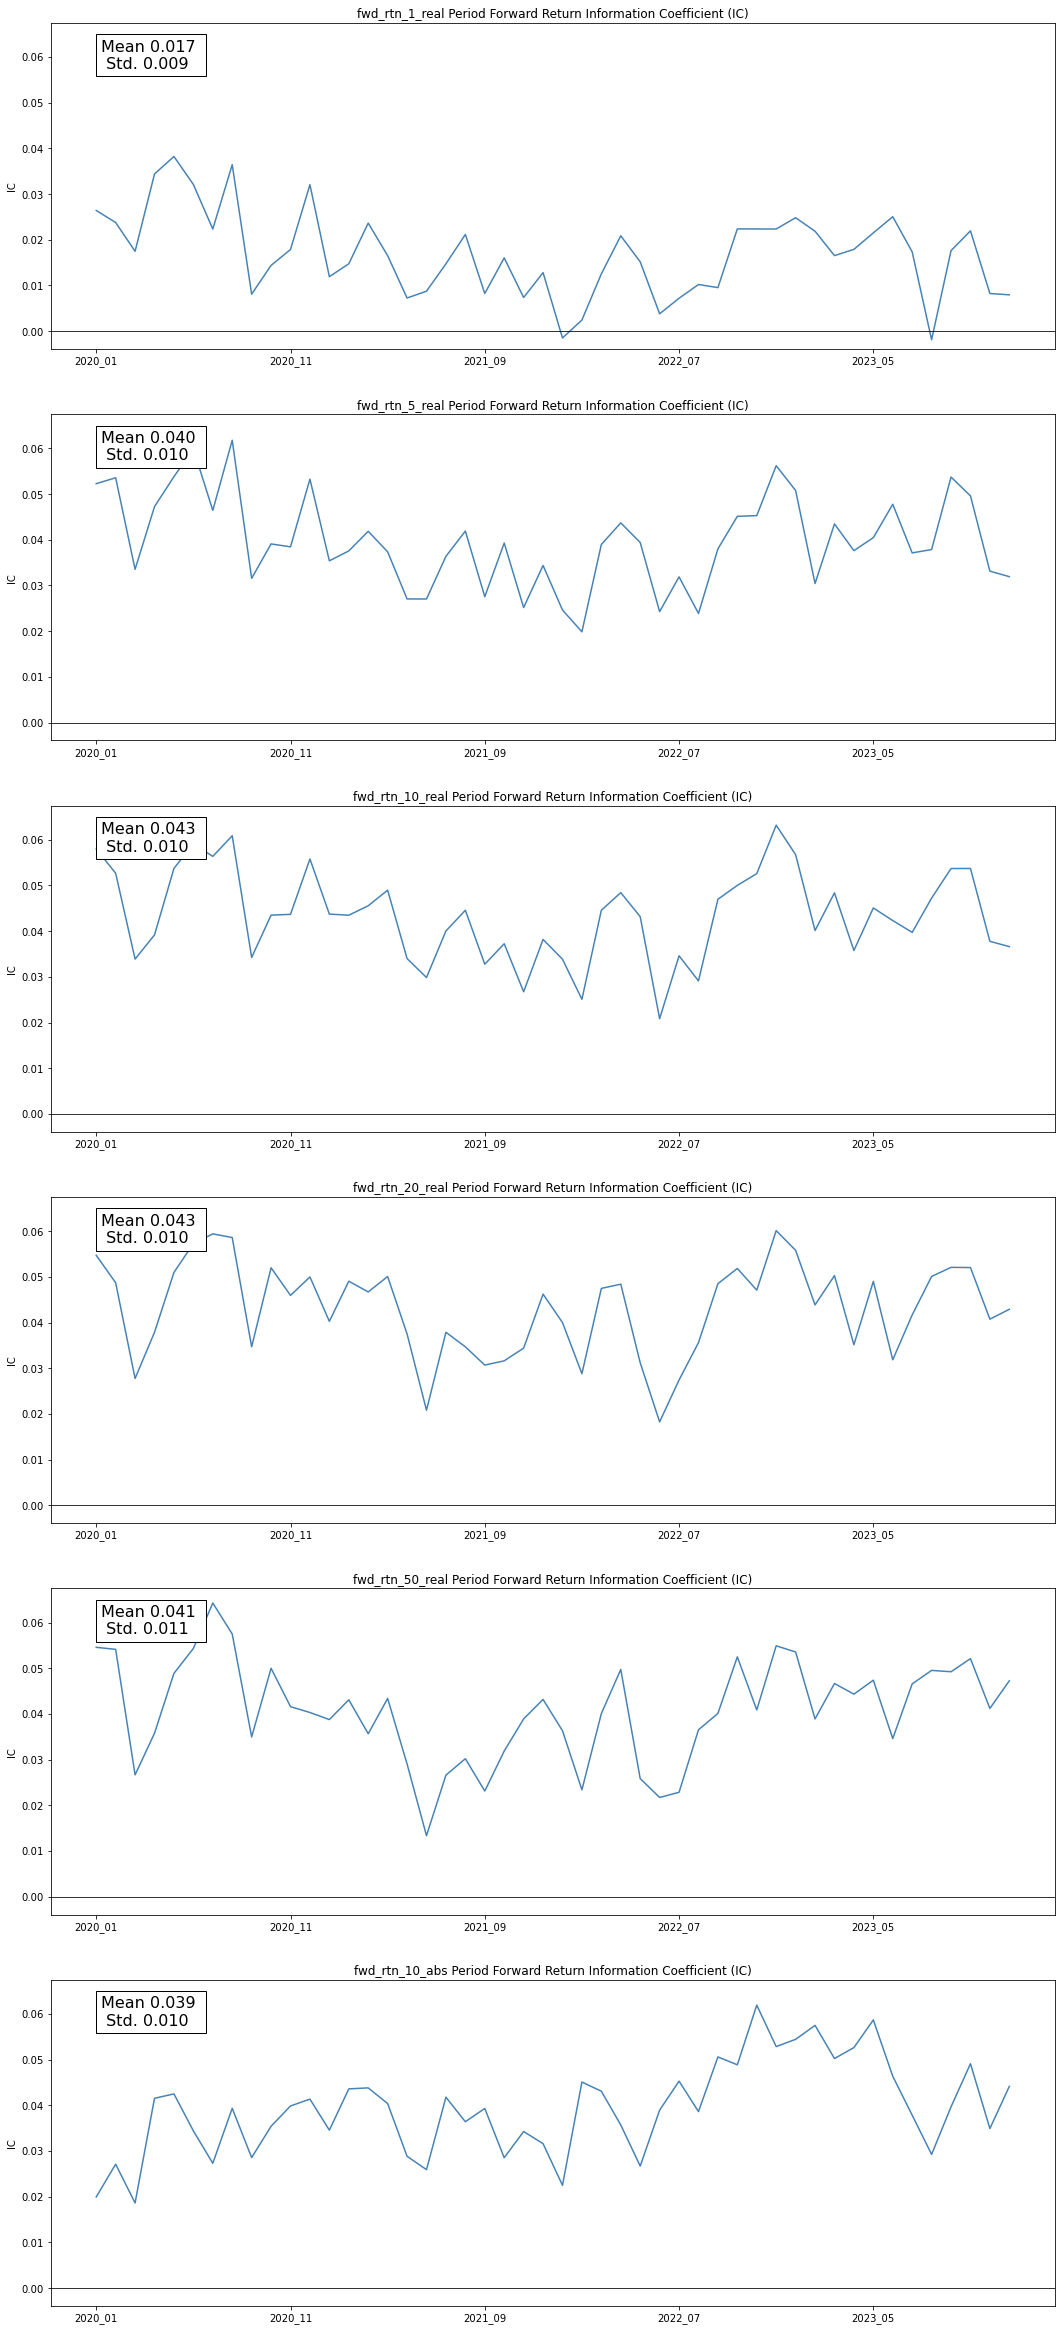

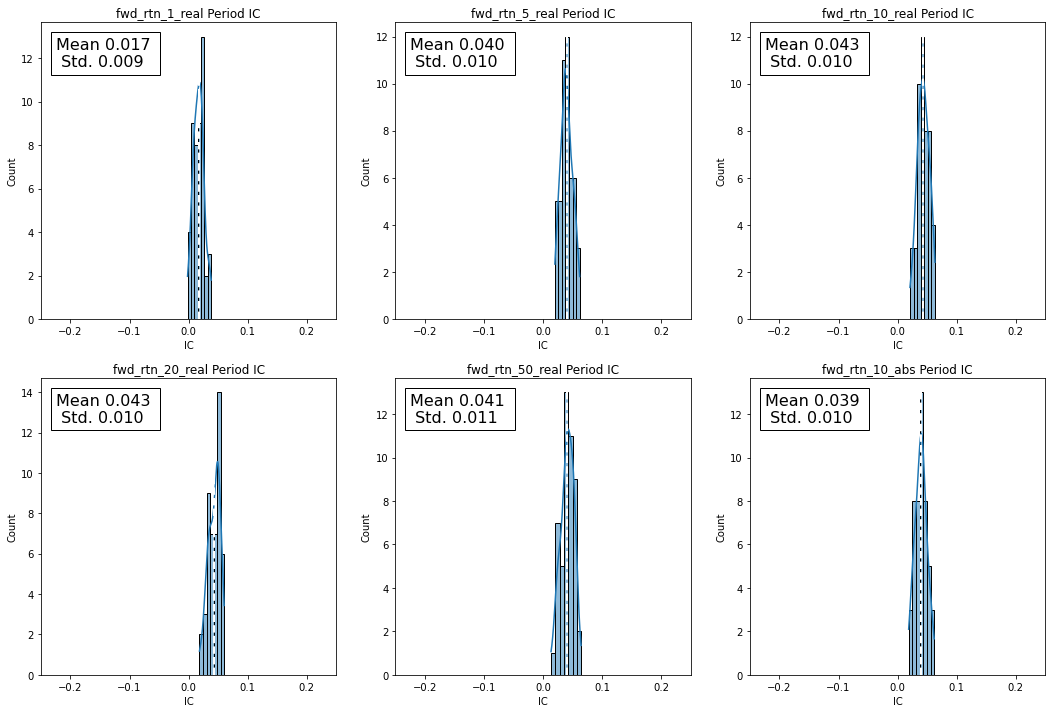

In [28]:
tests_factor_name='supply_imb'
print(f'Factor: {tests_factor_name}')
month_mean_ic = perf.cal_monthly_mean_ic(dl, factor_name=tests_factor_name, use_real_rtn=True)
# 保存记录
dl.set_record_df(kind='Info', factor_name=tests_factor_name, result_df=month_mean_ic)
# 读取记录，并且展示作图
month_mean_ic = dl.get_record_df(kind='Info', factor_name=tests_factor_name)
plotting.plot_information_table(month_mean_ic)
plotting.plot_ic_qq(month_mean_ic)
plotting.plot_ic_ts(month_mean_ic)
plotting.plot_ic_hist(month_mean_ic)
plt.show()

Factor: demand_exh_X
Information Analysis


,fwd_rtn_1_real,fwd_rtn_5_real,fwd_rtn_10_real,fwd_rtn_20_real,fwd_rtn_50_real,fwd_rtn_10_abs
IC Mean,-0.008,-0.039,-0.029,-0.013,-0.000,0.001
IC Std.,0.016,0.014,0.011,0.009,0.007,0.005
Risk-Adjusted IC,-0.484,-2.834,-2.582,-1.517,-0.074,0.263
t-stat(IC),-3.352,-19.636,-17.889,-10.509,-0.515,1.820
p-value(IC),0.002,0.000,0.000,0.000,0.609,0.075
IC Skew,1.992,0.671,0.569,0.680,0.157,-0.111
IC Kurtosis,5.280,1.134,0.523,0.260,-0.582,0.145


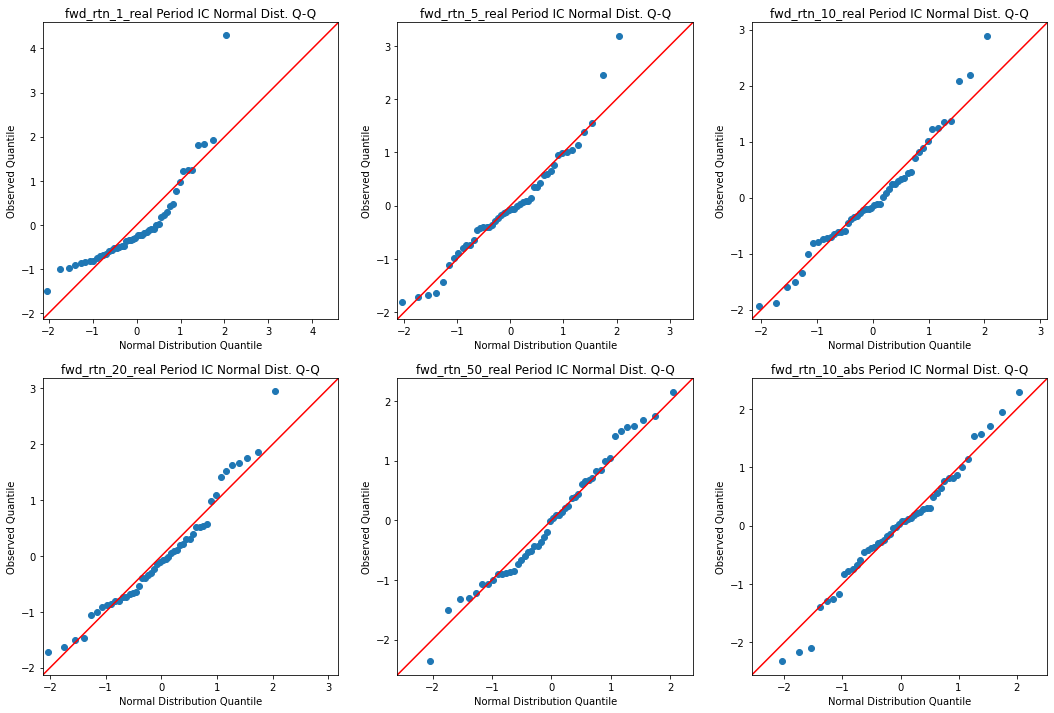

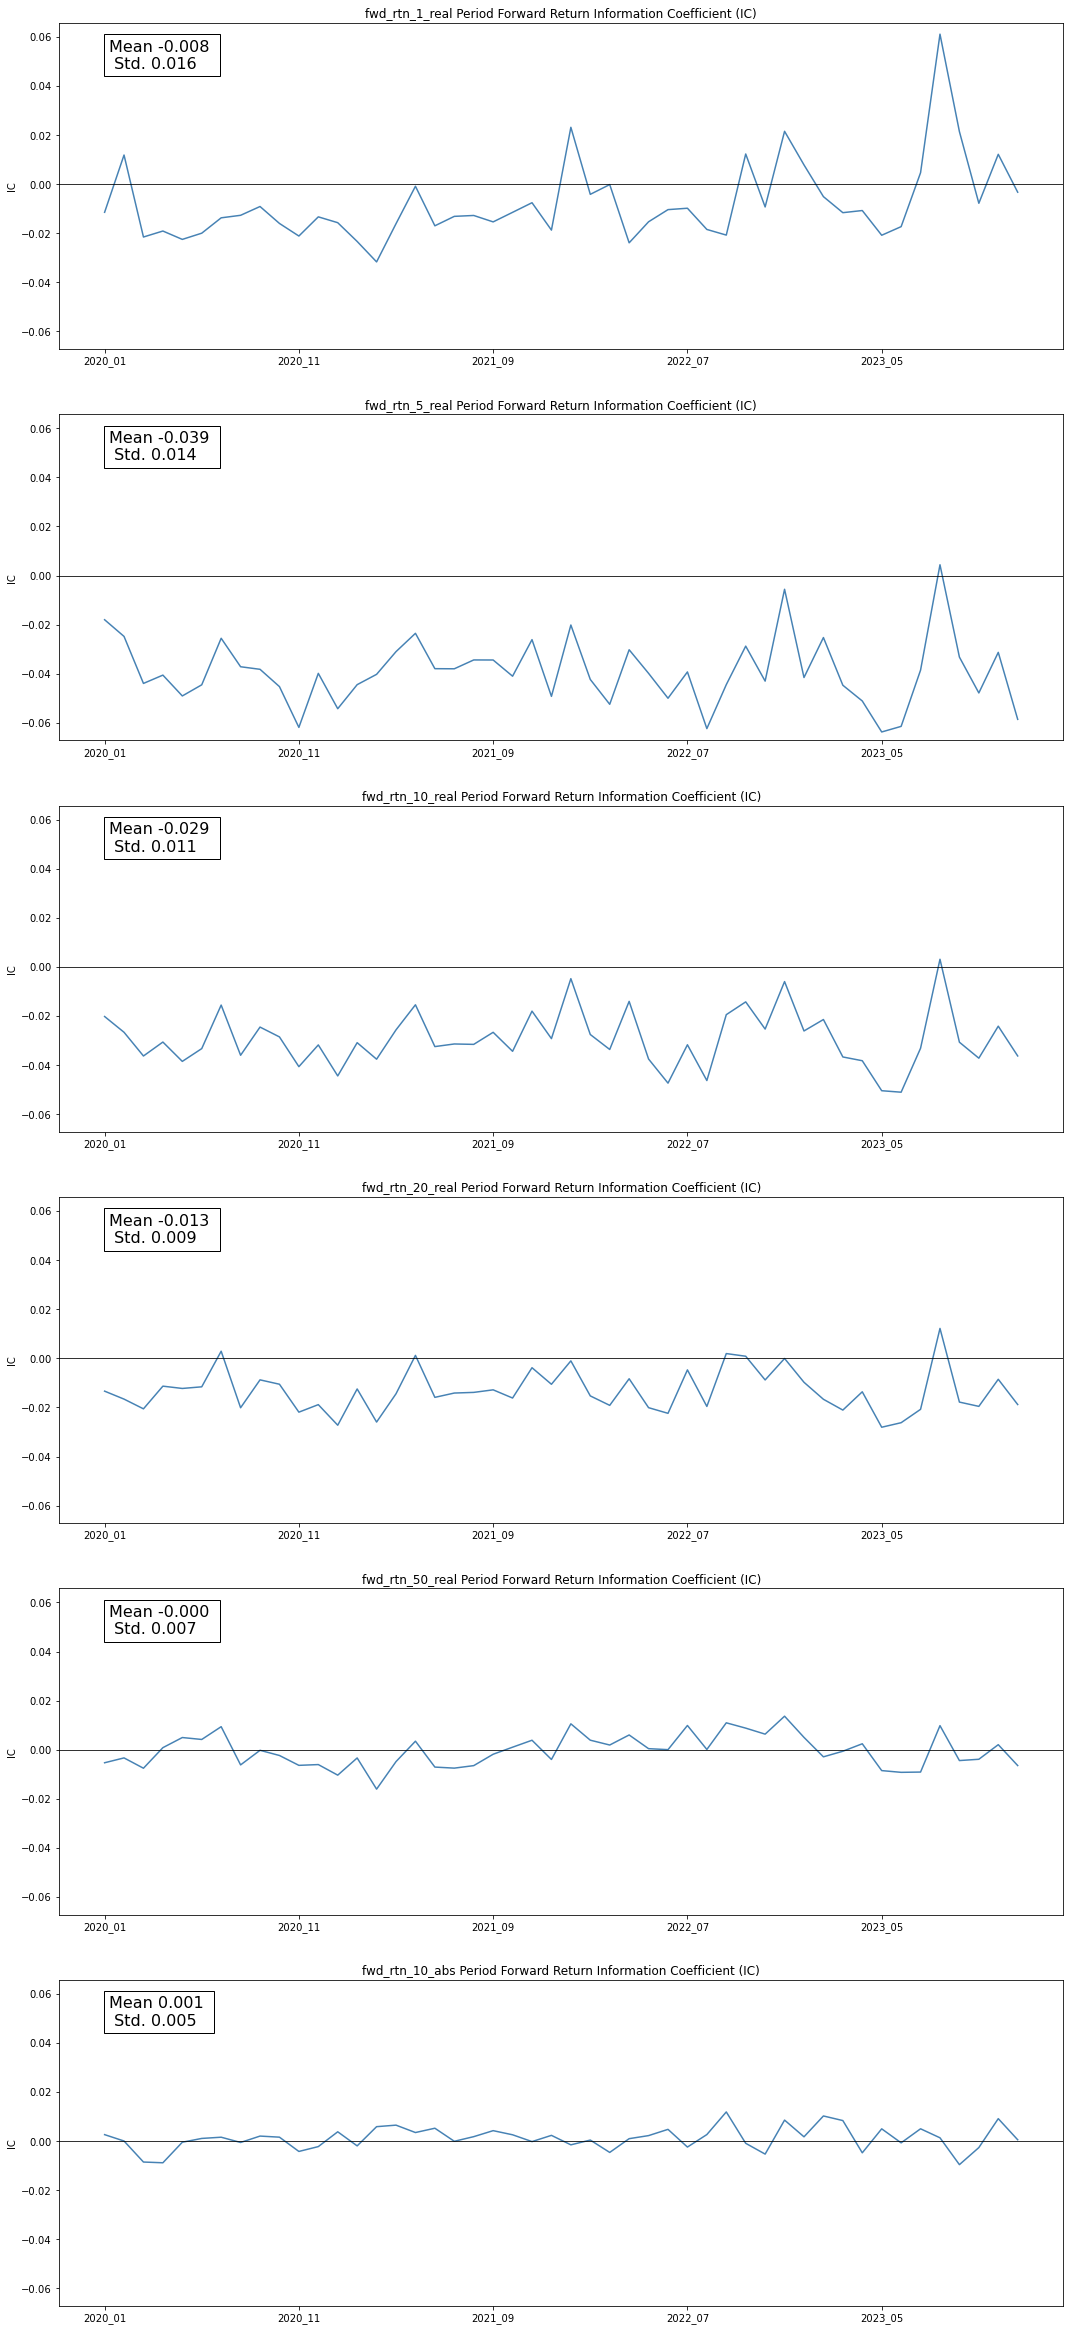

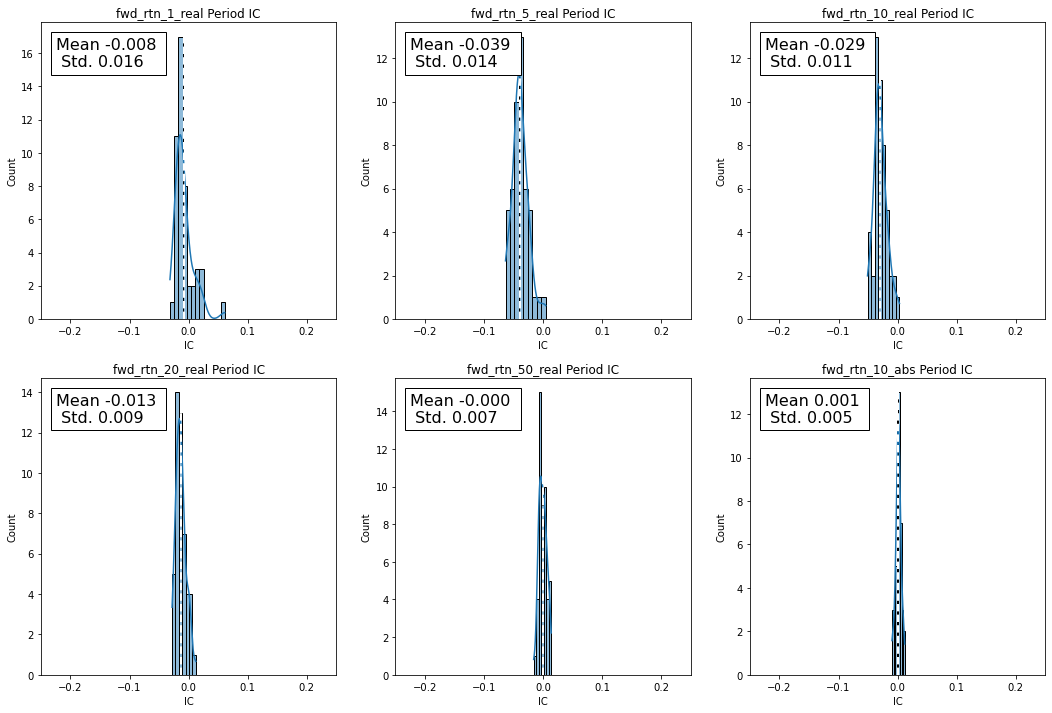

In [25]:
tests_factor_name='demand_exh_X'
print(f'Factor: {tests_factor_name}')
month_mean_ic = perf.cal_monthly_mean_ic(dl, factor_name=tests_factor_name, use_real_rtn=True)
# 保存记录
dl.set_record_df(kind='Info', factor_name=tests_factor_name, result_df=month_mean_ic)
# 读取记录，并且展示作图
month_mean_ic = dl.get_record_df(kind='Info', factor_name=tests_factor_name)
plotting.plot_information_table(month_mean_ic)
plotting.plot_ic_qq(month_mean_ic)
plotting.plot_ic_ts(month_mean_ic)
plotting.plot_ic_hist(month_mean_ic)
plt.show()